# HRP assay with Prx decamer reactions

This notebook performs analyses described in the 

**Manuscript:**

Modelling the decamerisation cycle of PRDX1 and the inhibition-like effect on its peroxidase activity

**Authors:**

C. Barry, C. Pillay, J. Rohwer

**Purpose:**

Performs assays with the above models with all components at equilibrium

Performs assays with the above models with components diluting

Performs assays to determine the oxidation and/or oligomer status with above models 

Plots: Figures 7a, 7b, 8c, and 8d

**Requirements:**

Python libraries (see **Imports** below)

Prx parameters (filename: `fitted_koff_kon_PRDX1_params.csv`)

A .png from Manta 2008

HRP PRDX2 no decamers (filename: `HRP_PRDX2.psc`)

HRP PRDX2 with decamers (filename: `HRP_PRDX2_decfull.psc`)

##### Imports

In [1]:
import os
import copy
from IPython.core.display import Image, display 
import math

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
from sklearn.linear_model import LinearRegression

import pysces


/tmp/ipykernel_96251/2427741436.py:3: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


Matplotlib backend set to: "nbAgg"
Matplotlib interface loaded (pysces.plt.m)
Pitcon routines available
NLEQ2 routines available
SBML support available
You are using NumPy (1.23.5) with SciPy (1.9.3)
Assimulo CVode available
RateChar is available
Parallel scanner is available

PySCeS environment
******************
pysces.model_dir = /home/chris/Pysces/psc
pysces.output_dir = /home/chris/Pysces


***********************************************************************
* Welcome to PySCeS (1.0.3) - Python Simulator for Cellular Systems   *
*                http://pysces.sourceforge.net                        *
* Copyright(C) B.G. Olivier, J.M. Rohwer, J.-H.S. Hofmeyr, 2004-2022  *
* Triple-J Group for Molecular Cell Physiology                        *
* Stellenbosch University, ZA and VU University Amsterdam, NL         *
* PySCeS is distributed under the PySCeS (BSD style) licence, see     *
* LICENCE.txt (supplied with this release) for details                *
* Please cite PySCeS with

###### Save directories

In [2]:
prev_dir = os.path.split(os.getcwd())[0]

mod_dir = os.path.join(prev_dir,"models")
if not os.path.isdir(mod_dir): os.mkdir(mod_dir) # ensure dir exists

par_dir = os.path.join(prev_dir,"params")
if not os.path.isdir(par_dir): os.mkdir(par_dir) # ensure dir exists
    
fig_dir = os.path.join(os.getcwd(),"Figures")
if not os.path.isdir(fig_dir): os.mkdir(fig_dir) # ensure dir exists


###### Matplotlib stuff

In [3]:
%matplotlib inline

mpl_width = 4.5
mpl_height = 3.5
mpl_dpi = 600
mpl_xlabel_fontsize = "large"
mpl_ylabel_fontsize = "large"
mu = "\u03bc"
color_wheel = ['tab:blue',"tab:green","tab:red","tab:cyan","tab:purple"]

In [4]:
HRP_no_dec_marker= "^"
HRP_dec_marker = "s"
HRP_dec_dil_marker = "o"
mpl_marker_size = 6

##### fitted params

In [5]:
df_onestep_params = pd.read_csv(os.path.join(par_dir,"fitted_koff_kon_PRDX1_params.csv"))
df_onestep_params.set_index("Parameter",inplace=True)

In [6]:
def update_params_BenfeitasModels(mod,params,hyp=False):
    """
    Updates the parameters of a model which has been augmented with Prx decamer reactions.
    Adding the decamer reactions introduces several new parameter names which need to be populated with their 
    corrosponding values in the original model as well as the fitted dimer-decamer transition koff and kon.
    As a special case: The decamer sulfenilation rate is set to the original model dimer sulfenilation rate 
    (i.e full activity) and the dimer sulfenilation rate is set to 100-fold less than the original model.
    """
    # Dimer-decamer transition params
    mod.exponent = 5
    mod.k_Prx_asso = params.loc["kon"][0]
    mod.k_Prx_dec_disasso = params.loc["koff"][0]
    
    ## Prx oxidation params
    mod.k_Prx_sulfe_SH_dec = mod.kprx
    mod.k_Prx_sulfe_SOH_dec = mod.kprx
    mod.k_Prx_disulf_form_SH_dec = mod.kcond
    mod.k_Prx_disulf_form_SOH_dec = mod.kcond
    mod.k_Prx_disso_SH_dec = 10000 # Arbitrary 
    mod.k_Prx_disso_SOH_dec = 10000 # Arbitrary
    
    if hyp == True:
        mod.k_Prx_sulfe_SOOH_dec = mod.kprx
        mod.k_Prx_sulfi_SOOH_dec = mod.ksulf
        mod.k_Prx_disulf_form_SOOH_dec = mod.kcond
        mod.k_Prx_srx_SOOH_dec = mod.ksrx 
        mod.k_Prx_disso_SOOH_dec = 10000 # Arbitrary
        
    # Adust dimer sulfenilation to be 100 slower than decamer
    mod.kprx = mod.kprx/100
#     mod.two_times_kprx = mod.two_times_kprx/100
    
    return mod

## HRP assay functions and params

In [7]:
def do_HRP_exp(mod,Prx_init_range,dil_factor=1,assay_end=0.1,assay_points=100):
    """
    Performs a HRP experiment by simulating HRP traces and processing the data.
    Requires "a_factor" as a GLOBAL 
    """
        
    # HRP only trace
    trace_HRP_only = do_HRP_assay(mod,"SH_SH_init",0,end_time=assay_end)
    
    # Assay traces
    vary = "SH_SH_init"
    traces = list(map(lambda Prx_init: do_HRP_assay(mod, 
                                                    vary,
                                                    Prx_init,
                                                     dil_factor=dil_factor,
                                                    end_time=assay_end),
                     Prx_init_range))
    
    # Calculate fraction inhibition
    f_inhi = list(map(lambda trace: calc_f_inhi(trace,trace_HRP_only,mod),traces))
    f_inhi = np.array((Prx_init_range,f_inhi)).transpose()
    
    # fit rate constant to fraction inhibition
    f_inhi_lm = LinearRegression().fit(f_inhi[:,0].reshape(-1,1),f_inhi[:,1])
        
    rate_constant = f_inhi_lm.coef_[0]
    
    return (traces,f_inhi,f_inhi_lm,rate_constant)

def do_HRP_assay(mod,
                vary,
              vary_init, 
              dil_factor=1,
              end_time=0.1,
              points=100):
    """
    Simulates a HRP assay trace.
    Requires "a_factor" as a GLOBAL 
    """
    # Copy model so adjustments don't affect upcoming simulations
    mod_copy = copy.deepcopy(mod)

    # Set H2O2 to zero for pre-assay equilibrium
    H2O2_orig = getattr(mod_copy, "H2O2_init")
    setattr(mod_copy,"H2O2_init",0.0)
    
    # Set expicit experimental concentration
    vary_orig = getattr(mod_copy,vary)
    setattr(mod_copy,vary,vary_init)

    # Adjust all species for dilution (no effect if dilution_factor=1)
    for species in mod_copy.species:
        setattr(mod_copy, f"{species}_init",getattr(mod_copy,f"{species}_init")*dil_factor)
        
    # Get pre-assay equilibrium
    mod_copy.doSim(end=1000000,points=2)

    # Set assay concentrations and scale to dilution
    for species in mod_copy.species:
        setattr(mod_copy, f"{species}_init",mod_copy.sim[species][-1]/dil_factor)
    setattr(mod_copy,"H2O2_init",H2O2_orig)

    # Do Sim
    mod_copy.sim_end = end_time
    mod_copy.sim_points = points
    mod_copy.Simulate()

    # Grab data
    assay_time = mod_copy.sim["Time"]
    assay_absorbance = mod_copy.sim["compound_I"]*a_factor
    trace = np.array((assay_time,assay_absorbance)).transpose()

    return trace

def calc_f_inhi(trace, trace_HRP_only, mod):
    """
    Calculates the fractional inhibition of a HRP trace.
    """
    # Takes the mean of the last 25% of points in order to account for noise
    delta_max = trace_HRP_only[-math.floor(len(trace_HRP_only)/4):,1].mean()
    delta_obs = trace[-math.floor(len(trace)/4):,1].mean()
    k_HRP = getattr(mod,"k_HRP")
    HRP_init = getattr(mod,"HRP_init")
    f_inhi = k_HRP*HRP_init*((delta_max - delta_obs)/delta_obs)         
    return f_inhi

##### Assay parameters

In [8]:
# The absorbace change will be determined using the Beer-Lambert law: A = ecl
c = 10**(-6) # Analysis is in micro Molar
l = 1    # Light path of reader
delta_e398_compound_I = -4.2 * 10**4 # HRP breaks down into compound_I which is measured spectrophotometrically
# Hayashi, Y., and Yamazaki, I. (1979). The oxidation-reduction potentials of compoundI/compound II and compound II/ferric couples of horseradish peroxidases A2 and C. J. Biol. Chem. 254, 9101–9106.
a_factor = delta_e398_compound_I * c * l # A per umol HRP (or Compound_I)

## Assay at equilibrium (figure 7a and 7b)

"Standard" HRP assay replicating Manta 2009 fig2

Paper: The peroxidase and peroxynitrite reductase activity of human erythrocyte peroxiredoxin 2

Fig. 2. Kinetics of human Prx2 oxidation by hydrogen peroxide studied by a competitive kinetic approach. Time courses of HRP (5 lM) oxidation by H2O2 (1 lM) in the presence of pre-reduced Prx2 (from bottom to top 0, 0.4, 0.8, 1.3, and 1.7 lM) in 100 mM potassium phosphate buffer pH 7.4 plus 0.1 mM dtpa at 25 °C. From the concentration of compound I formed at each Prx2 concentration, a value of k2 was calculated using Eq. (3).

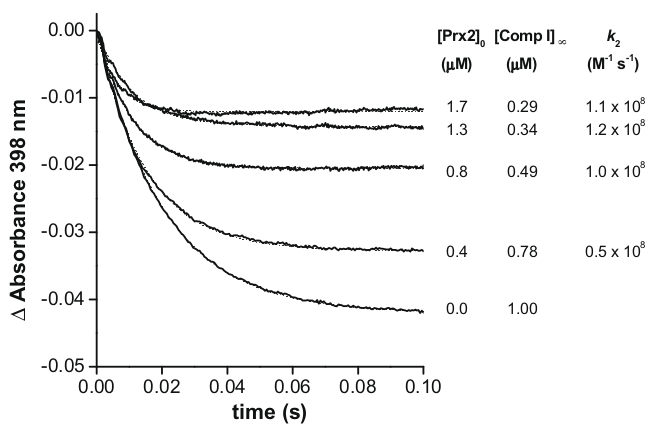

In [9]:
Image("Manta 2009 Fig2.png")

In [10]:
# Manta's experimental conditions
exp_H2O2_manta = 1
exp_HRP_manta = 5
Prx_init_range_manta = np.array([0.0,0.4,0.8,1.3,1.70])
assay_end_manta = 0.1

In [11]:
# Load models and update with exp conditions

# HRP Prx no decamers
mod_HRP_Prx_no_dec = pysces.model("HRP_PRDX2.psc", dir=mod_dir)
mod_HRP_Prx_no_dec.mode_integrator = 'CVODE'
setattr(mod_HRP_Prx_no_dec,"H2O2_init",exp_H2O2_manta)
setattr(mod_HRP_Prx_no_dec,"HRP_init",exp_HRP_manta)

# HRP Prx with decamers
mod_HRP_Prx_with_dec = pysces.model("HRP_PRDX2_decfull.psc", dir=mod_dir)
mod_HRP_Prx_with_dec.mode_integrator = 'CVODE'
mod_HRP_Prx_with_dec = update_params_BenfeitasModels(mod_HRP_Prx_with_dec,df_onestep_params)
setattr(mod_HRP_Prx_with_dec,"H2O2_init",exp_H2O2_manta)
setattr(mod_HRP_Prx_with_dec,"HRP_init",exp_HRP_manta)


Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/HRP_PRDX2.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/HRP_PRDX2.psc
Info: No reagents have been fixed
Info: "kred" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . . . .  done.
Calculating K matrix . . . . . . . . . . .  done.
 
Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/HRP_PRDX2_decfull.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/HRP_PRDX2_decfull.psc
Info: No reagents have been fixed
Info: "kred" has bee

In [12]:
# Do HRP experiment simulations
assay_points = 100

mod = mod_HRP_Prx_no_dec
HRP_exp_no_dec_manta = do_HRP_exp(mod,
                                  Prx_init_range_manta,
                                  assay_end=assay_end_manta,
                                  assay_points=assay_points)

mod = mod_HRP_Prx_with_dec
HRP_exp_with_dec_manta = do_HRP_exp(mod,
                                    Prx_init_range_manta,
                                    assay_end=assay_end_manta,
                                    assay_points=assay_points)

CVODE time for 2 points: 0.005980968475341797
CVODE time for 100 points: 0.009406328201293945
CVODE time for 2 points: 0.0008687973022460938
CVODE time for 100 points: 0.009228706359863281
CVODE time for 2 points: 0.0008056163787841797
CVODE time for 100 points: 0.012398004531860352
CVODE time for 2 points: 0.0008139610290527344
CVODE time for 100 points: 0.013126611709594727
CVODE time for 2 points: 0.0008592605590820312
CVODE time for 100 points: 0.013023138046264648
CVODE time for 2 points: 0.0007984638214111328
CVODE time for 100 points: 0.012474775314331055
CVODE time for 2 points: 0.04563188552856445
CVODE time for 100 points: 0.22801637649536133
CVODE time for 2 points: 0.0509495735168457
CVODE time for 100 points: 0.24029278755187988
CVODE time for 2 points: 0.21470975875854492
CVODE time for 100 points: 0.31014513969421387
CVODE time for 2 points: 0.3079707622528076
CVODE time for 100 points: 0.2866942882537842
CVODE time for 2 points: 0.3046293258666992
CVODE time for 100 poi

/tmp/ipykernel_96251/2091389963.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


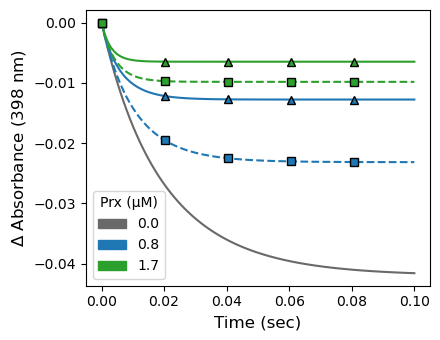

In [13]:
# Plot traces
# Assign data
HRP_no_dec_traces = HRP_exp_no_dec_manta[0]
HRP_with_dec_traces = HRP_exp_with_dec_manta[0]

# Plot subset of results
cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

handle_list = []

axarr.plot(HRP_no_dec_traces[0][:,0], HRP_no_dec_traces[0][:,1],color="dimgrey") 
handle = mpatches.Patch(color="dimgrey", label = f"0.0")
handle_list.append(handle)

Prx_init_range_temp = [Prx_init_range_manta[2],Prx_init_range_manta[4]]

for count,trace in enumerate([HRP_no_dec_traces[2],HRP_no_dec_traces[4]]):
    axarr.plot(trace[:,0], 
               trace[:,1], 
               f"{color_wheel[count]}",
               marker=HRP_no_dec_marker,
               markevery=20,
               markersize = mpl_marker_size,
              mec = 'k') 
    handle = mpatches.Patch(color=f"{color_wheel[count]}", label = f"{Prx_init_range_temp[count]}")
    handle_list.append(handle)
    
for count,trace in enumerate([HRP_with_dec_traces[2],HRP_with_dec_traces[4]]):
    axarr.plot(trace[:,0], 
               trace[:,1],
               f"{color_wheel[count]}",
               linestyle="--",
               marker=HRP_dec_marker,
               markevery=20,
               markersize = mpl_marker_size,
              mec = 'k')
    
axarr.set_xlabel("Time (sec)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel("$\Delta$ Absorbance (398 nm)",fontsize=mpl_ylabel_fontsize)

axarr.legend(handles=handle_list,title=f"Prx ({mu}M)")
f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"hrp_equi_abs398_v_time.pdf"),dpi= mpl_dpi)

/tmp/ipykernel_96251/106155310.py:52: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


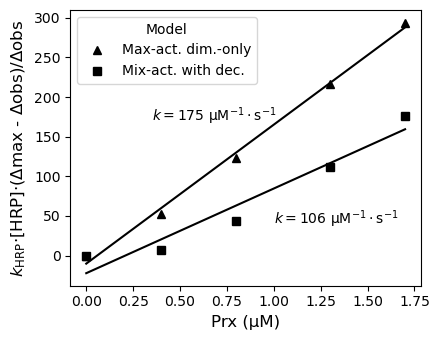

In [14]:
# Plot f inhi
# Assign data
HRP_no_dec_f_inhi = HRP_exp_no_dec_manta[1]
HRP_no_dec_finhi_lm= HRP_exp_no_dec_manta[2]
HRP_no_dec_k= HRP_exp_no_dec_manta[3]

HRP_with_dec_f_inhi = HRP_exp_with_dec_manta[1]
HRP_with_dec_finhi_lm= HRP_exp_with_dec_manta[2]
HRP_with_dec_k= HRP_exp_with_dec_manta[3]

# Plot results
cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

axarr.plot(HRP_no_dec_f_inhi[:,0], 
           HRP_no_dec_f_inhi[:,1], 
           color=f"k",
           linestyle='None',
           marker=HRP_no_dec_marker,
           markersize = mpl_marker_size,
           label=f"Max-act. dim.-only") 
axarr.plot(HRP_no_dec_f_inhi[:,0], 
           HRP_no_dec_finhi_lm.predict(HRP_no_dec_f_inhi[:,0].reshape(-1,1)),
          f"k",
          linestyle="-")
axarr.text(0.35,170,f"$k={str(HRP_no_dec_k)[0:3]}\ \mathregular{{{mu}M^{{-1}}\cdot s^{{-1}}}}$")

axarr.plot(HRP_with_dec_f_inhi[:,0], 
           HRP_with_dec_f_inhi[:,1], 
           color=f"k",
           linestyle='None',
           marker=HRP_dec_marker,
           markersize = mpl_marker_size,
           label=f"Mix-act. with dec.") 
axarr.plot(HRP_with_dec_f_inhi[:,0], 
           HRP_with_dec_finhi_lm.predict(HRP_with_dec_f_inhi[:,0].reshape(-1,1)),
          f"k",
          linestyle="-")
axarr.text(1.,40,f"$k={str(HRP_with_dec_k)[0:3]}\ \mathregular{{{mu}M^{{-1}}\cdot s^{{-1}}}}$")


axarr.set_xlabel(f"Prx ({mu}M)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel("$k\mathregular{{_{{HRP}}}}$$\cdot$[HRP]$\cdot$($\Delta$max - $\Delta$obs)/$\Delta$obs",fontsize=mpl_ylabel_fontsize)

# axarr.set_ylim(bottom=0)
# axarr.set_xlim(left=0)
axarr.legend(title="Model")
f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"hrp_equi_finhi_v_Prx.pdf"),dpi=mpl_dpi)


## Assay after dilution (figure 8c and 8d)

Compare HRP assays with species equilibrating on injection to HRP assays with species equilibrating before injection. HRP and H2O2 concentrations based on Manta 2009.

In [15]:
Prx_init_range_dil = np.array([0.5,2,5])


In [16]:
# Load model

# HRP Prx with decamers
mod_HRP_Prx_with_dec = pysces.model("HRP_PRDX2_decfull.psc", dir=mod_dir)
mod_HRP_Prx_with_dec.mode_integrator = 'CVODE'
mod_HRP_Prx_with_dec = update_params_BenfeitasModels(mod_HRP_Prx_with_dec,df_onestep_params)
setattr(mod_HRP_Prx_with_dec,"H2O2_init",exp_H2O2_manta)
setattr(mod_HRP_Prx_with_dec,"HRP_init",exp_HRP_manta)

Using model directory: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models
/home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/HRP_PRDX2_decfull.psc loading ..... 
Parsing file: /home/chris/Dropbox/Studies/6. PhD/Papers [Chris B]/Decamerisation_cycle_of_PRDX1/Data/models/HRP_PRDX2_decfull.psc
Info: No reagents have been fixed
Info: "kred" has been initialised but does not occur in a rate equation
 
Calculating L matrix . . . . . . . . .  done.
Calculating K matrix . . . . . . . . . . . . . . .  done.
 


In [17]:
# Do HRP experiment simulations
assay_points = 100
mod = mod_HRP_Prx_with_dec
dilution = 1
HRP_exp_with_dec_no_dil = do_HRP_exp(mod,
                                  Prx_init_range_dil,
                                  dil_factor=dilution,
                                  assay_end=assay_end_manta,
                                  assay_points=assay_points)

dilution = 10
HRP_exp_with_dec_with_dil = do_HRP_exp(mod,
                                    Prx_init_range_dil,
                                    dil_factor=dilution,
                                    assay_end=assay_end_manta,
                                    assay_points=assay_points)

CVODE time for 2 points: 0.045928239822387695
CVODE time for 100 points: 0.2167644500732422
CVODE time for 2 points: 0.190169095993042
CVODE time for 100 points: 0.27323341369628906
CVODE time for 2 points: 0.3771018981933594
CVODE time for 100 points: 0.289172887802124
CVODE time for 2 points: 0.6511702537536621
CVODE time for 100 points: 0.2829406261444092
CVODE time for 2 points: 0.04418540000915527
CVODE time for 100 points: 0.2093648910522461
CVODE time for 2 points: 0.6605250835418701
CVODE time for 100 points: 0.28163790702819824
CVODE time for 2 points: 0.7261087894439697
CVODE time for 100 points: 0.35545778274536133
CVODE time for 2 points: 1.0732300281524658
CVODE time for 100 points: 0.35601067543029785


/tmp/ipykernel_96251/2923413653.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


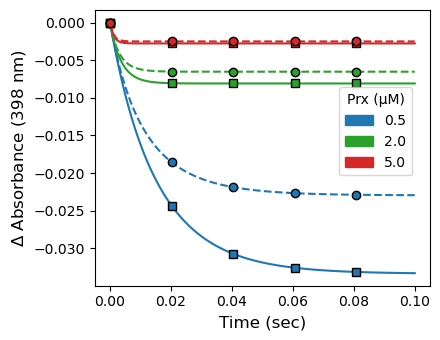

In [18]:
# Plot traces
# Assign data
HRP_no_dil_traces = HRP_exp_with_dec_no_dil[0]
HRP_with_dil_traces = HRP_exp_with_dec_with_dil[0]

# Plot results
cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

handle_list = []

for count,trace in enumerate(HRP_no_dil_traces):
    axarr.plot(trace[:,0], 
               trace[:,1], 
               f"{color_wheel[count]}",
               marker=HRP_dec_marker,
               markevery=20,
               markersize = mpl_marker_size,
               mec = 'k') 
    handle = mpatches.Patch(color=f"{color_wheel[count]}", label = f"{Prx_init_range_dil[count]}")
    handle_list.append(handle)
    
for count,trace in enumerate(HRP_with_dil_traces):
    axarr.plot(trace[:,0], 
               trace[:,1], 
               f"{color_wheel[count]}",
               linestyle="--",
               marker=HRP_dec_dil_marker,
               markevery=20,
               markersize = mpl_marker_size,
               mec = 'k')
    
axarr.set_xlabel("Time (sec)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel("$\Delta$ Absorbance (398 nm)",fontsize=mpl_ylabel_fontsize)

axarr.legend(handles=handle_list,title=f"Prx ({mu}M)",loc=(0.73,0.4))
f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"hrp_dil_abs398_v_time.pdf"),dpi= mpl_dpi)


/tmp/ipykernel_96251/3338960500.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


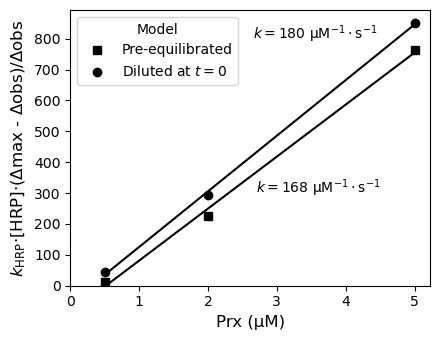

In [19]:
# Plot f inhi
# Assign data
HRP_no_dil_f_inhi = HRP_exp_with_dec_no_dil[1]
HRP_no_dil_finhi_lm= HRP_exp_with_dec_no_dil[2]
HRP_no_dil_k= HRP_exp_with_dec_no_dil[3]

HRP_with_dil_f_inhi = HRP_exp_with_dec_with_dil[1]
HRP_with_dil_finhi_lm= HRP_exp_with_dec_with_dil[2]
HRP_with_dil_k= HRP_exp_with_dec_with_dil[3]

# Plot results
cols = 1
rows = 1

f, axarr = plt.subplots(rows, cols)
f.set_size_inches(w=mpl_width, h=mpl_height)

axarr.plot(HRP_no_dil_f_inhi[:,0], 
           HRP_no_dil_f_inhi[:,1], 
           color=f"k",
           linestyle="None",
           marker=HRP_dec_marker,
           markersize = mpl_marker_size,
          label=f"Pre-equilibrated") 
axarr.plot(HRP_no_dil_f_inhi[:,0], 
           HRP_no_dil_finhi_lm.predict(HRP_no_dil_f_inhi[:,0].reshape(-1, 1)),
          f"k-")
axarr.text(2.7,300,f"$k={str(HRP_no_dil_k)[0:3]}\ \mathregular{{{mu}M^{{-1}}\cdot s^{{-1}}}}$")

axarr.plot(HRP_with_dil_f_inhi[:,0], 
           HRP_with_dil_f_inhi[:,1], 
           color=f"k",
           linestyle="None",
           marker=HRP_dec_dil_marker,
           markersize = mpl_marker_size,
          label=f"Diluted at $t=0$")
axarr.plot(HRP_with_dil_f_inhi[:,0], 
           HRP_with_dil_finhi_lm.predict(HRP_with_dil_f_inhi[:,0].reshape(-1, 1)),
          f"k-")
axarr.text(2.65,800,f"$k={str(HRP_with_dil_k)[0:3]}\ \mathregular{{{mu}M^{{-1}}\cdot s^{{-1}}}}$")

axarr.set_xlabel(f"Prx ({mu}M)", fontsize=mpl_xlabel_fontsize)
axarr.set_ylabel("$k\mathregular{{_{{HRP}}}}$$\cdot$[HRP]$\cdot$($\Delta$max - $\Delta$obs)/$\Delta$obs",fontsize=mpl_ylabel_fontsize)

axarr.set_ylim(bottom=0)
axarr.set_xlim(left=0)
axarr.legend(title="Model")
f.tight_layout()
f.show()
f.savefig(os.path.join(fig_dir,"hrp_dil_finhi_v_Prx.pdf"),dpi=mpl_dpi)
